In [102]:
import numpy as np
import torch
import tntorch as tn
import torch.nn as nn
import torch.nn.functional as F

from warnings import warn


import tensorfunbound as tfb
from tensorfunbound import custom_access_float, ModelConTT

In [103]:
import torch
import tntorch as tn
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy.io import loadmat
import os

from ipypb import ipb
tqdm_notebook = ipb
import time
#from skimage.morphology import erosion

In [104]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [105]:
data_path = '../../Downloads/05 Example/' #'/home/ab/Documents/DISK2TB/SaudiAramco/3D_geoproject/data/' 

In [106]:
rawMatData = loadmat(data_path+'Normal_1_0.5.mat')
#bwImage = rawMatData["bwImage"]
ctImage = rawMatData["ctImage"]

In [107]:
data3d = (ctImage>127)[:512:4,:512:4,:512:4].astype(np.float64)

In [108]:
RMAX = 40


# tt_data = tn.rand(data3d.shape, ranks_tt=RMAX, requires_grad=True, device=device)

<ipython-input-109-da035d6871d4>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.imshow(data3d[selection],  cmap='gray')


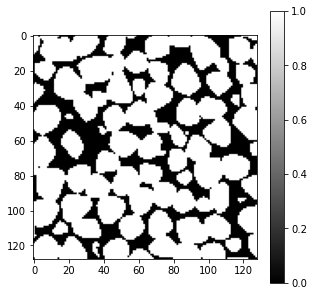

In [109]:
plt.figure(figsize=(5,5))

selection = [slice(None), slice(None), 12]

plt.imshow(data3d[selection],  cmap='gray')
plt.colorbar();

In [110]:
from ipypb import ipb
tqdm_notebook = ipb
import time

In [111]:
from torch.utils.data import Dataset, DataLoader

class discreteDataset(Dataset):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def __len__(self):
        return np.prod(self.shape)

    def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        indices = np.unravel_index(idx, self.shape)
        
        return indices

In [112]:
from ipypb import track

In [113]:
import edt
def sdf(dat):
    dat = dat.astype(dtype=np.float32)
    return edt.edt(dat) - edt.edt(1.-dat)

def tsdf(dat, mu=3):
    return sdf(dat).clip(-mu, mu)

In [114]:
data_tsdf = tsdf(data3d)

<ipython-input-115-ac6b23fcf280>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dat = data_tsdf[selection]


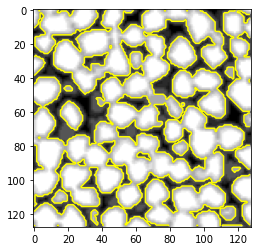

In [115]:
dat = data_tsdf[selection]
plt.imshow(dat, cmap='gray')
plt.contour(dat, levels=[0], colors=['yellow'])
# plt.colorbar()

<ipython-input-116-fa81a41e2454>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dat = tn.Tensor(data_tsdf, ranks_tt=RMAX).numpy()[selection]


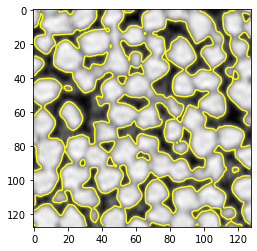

In [116]:
dat = tn.Tensor(data_tsdf, ranks_tt=RMAX).numpy()[selection]
plt.imshow(dat, cmap='gray')
plt.contour(dat, levels=[0], colors=['yellow'])

In [117]:
# model = nn.Sequential(
#                        ModelConTT(tt=None, 
#                        interpolation='closest', 
#                        RMAX=30, 
#                        Ns=data3d.shape,
#                        device=device),
#                     nn.Sigmoid())

model = ModelConTT(tt=None, 
                       interpolation='closest', 
                       RMAX=RMAX, 
                       Ns=data3d.shape,
                       device=device)

ds = discreteDataset(shape=data3d.shape)

sampler = torch.utils.data.sampler.BatchSampler(
    torch.utils.data.sampler.RandomSampler(ds),
    batch_size=2**14,
    drop_last=False)

dl = DataLoader(ds, sampler=sampler)

none


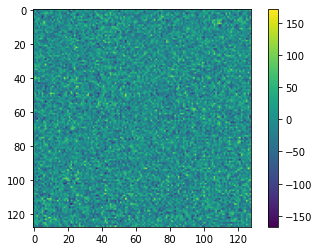

In [118]:
plt.imshow(model.tt.torch()[selection].detach().cpu())
plt.colorbar()

In [119]:
torch_data = torch.Tensor(data3d).to(device)

In [121]:
# L = torch.nn.BCELoss()
L = torch.nn.BCEWithLogitsLoss()
# L = torch.dist
n_epochs = 10
    
losses = []

for lr in [1e-1, 1e-2, 1e-3, 1e-4]:
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    for epoch in ipb(range(n_epochs)):
        for x in dl:
            optimizer.zero_grad()
            indices = torch.stack(x, dim=1).squeeze().T
            y_goal = torch_data[list(indices.T)]
            y_predicted = model(indices)
            loss = L(y_predicted, y_goal)
            loss.backward(retain_graph=True)
            optimizer.step()
            losses.append(loss.detach())

 [████████████████████████████████████████████████████████████] 10/10 [06:47<00:41, 40.72s/it]

 [████████████████████████████████████████████████████████████] 10/10 [07:04<00:42, 42.43s/it]

 [████████████████████████████████████████████████████████████] 10/10 [07:18<00:44, 43.78s/it]

 [████████████████████████████████████████████████████████████] 10/10 [07:31<00:45, 45.08s/it]

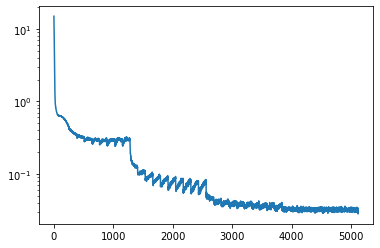

In [122]:
plt.semilogy(losses)

Text(0.5, 1.0, 'Data')

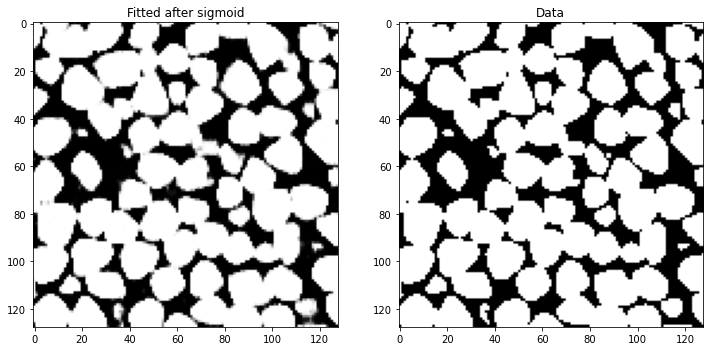

In [123]:
f, axs = plt.subplots(1,2,figsize=(12,12))
axs[0].imshow(model.tt.torch()[selection].sigmoid().detach().cpu(), cmap='gray')
axs[0].set_title("Fitted after sigmoid")
axs[1].imshow(torch_data[selection].detach().cpu(), cmap='gray')
axs[1].set_title("Data")

Text(0.5, 1.0, 'Data')

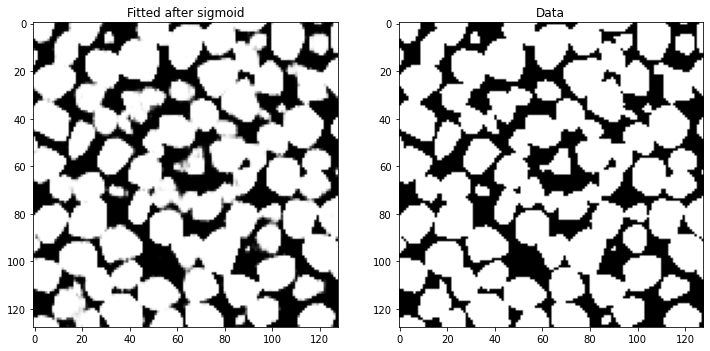

In [124]:
selection = [slice(None), slice(None), 80]
f, axs = plt.subplots(1,2,figsize=(12,12))
axs[0].imshow(model.tt.torch()[selection].sigmoid().detach().cpu(), cmap='gray')
axs[0].set_title("Fitted after sigmoid")
axs[1].imshow(torch_data[selection].detach().cpu(), cmap='gray')
axs[1].set_title("Data")

In [125]:
# f, axs = plt.subplots(1,2,figsize=(12,12))
# axs[0].imshow(model[0].tt.torch()[selection].detach().cpu(), cmap='viridis')
# axs[1].imshow(torch_data[selection].detach().cpu(), cmap='viridis')

# Sliced dataset

In [126]:
from torch.utils.data import Dataset, DataLoader

class SlicedDataset(Dataset):
    def __init__(self, shape, mask):
        super().__init__()
        self.shape = shape
        self.mask = mask
        self.indices = np.arange(np.prod(shape))[mask.flatten()]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        indices = np.unravel_index(idx, self.shape)
        
        return indices

In [127]:
# select central slices

mask = np.zeros_like(data3d, dtype=np.bool)
Nx, Ny, Nz = data3d.shape
mask[Nx//2] = True
mask[Ny//2] = True
mask[Nx//2] = True
ds_slices = SlicedDataset(data3d.shape, mask)

In [128]:
mask[Nx//2] 

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [129]:
mask.sum()

16384

In [130]:
mask.flatten().shape

(2097152,)

In [131]:
ds_slices.indices.shape

(16384,)

In [132]:
# model = nn.Sequential(
#                        ModelConTT(tt=None, 
#                        interpolation='closest', 
#                        RMAX=30, 
#                        Ns=data3d.shape,
#                        device=device),
#                     nn.Sigmoid())

model = ModelConTT(tt=None, 
                       interpolation='closest', 
                       RMAX=RMAX, 
                       Ns=data3d.shape,
                       device=device)

sampler = torch.utils.data.sampler.BatchSampler(
    torch.utils.data.sampler.RandomSampler(ds_slices),
    batch_size=512,
    drop_last=False)

dl = DataLoader(ds_slices, sampler=sampler)

none


In [133]:
ds_slices.mask.shape

(128, 128, 128)

In [134]:
ds_slices.indices

array([1048576, 1048577, 1048578, ..., 1064957, 1064958, 1064959])

In [135]:
def optimize(model, dataloader):
    # L = torch.nn.BCELoss()
    L = torch.nn.BCEWithLogitsLoss()
    # L = torch.dist
    n_epochs = 10

    losses = []

    for lr in [1e-1, 1e-2, 1e-3, 1e-4]:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        for epoch in ipb(range(n_epochs)):
            for x in dataloader:
                optimizer.zero_grad()
                indices = torch.stack(x, dim=1).squeeze().T
                y_goal = torch_data[list(indices.T)]
                y_predicted = model(indices)
                loss = L(y_predicted, y_goal)
                loss.backward(retain_graph=True)
                optimizer.step()
                losses.append(loss.detach())
    return losses

In [136]:
losses = optimize(model, dl)

 [████████████████████████████████████████████████████████████] 10/10 [00:05<00:01, 0.52s/it]

 [████████████████████████████████████████████████████████████] 10/10 [00:06<00:01, 0.56s/it]

 [████████████████████████████████████████████████████████████] 10/10 [00:06<00:01, 0.55s/it]

 [████████████████████████████████████████████████████████████] 10/10 [00:05<00:01, 0.54s/it]

In [137]:
selection = [slice(None), slice(None), 80]

Text(0.5, 1.0, 'Data')

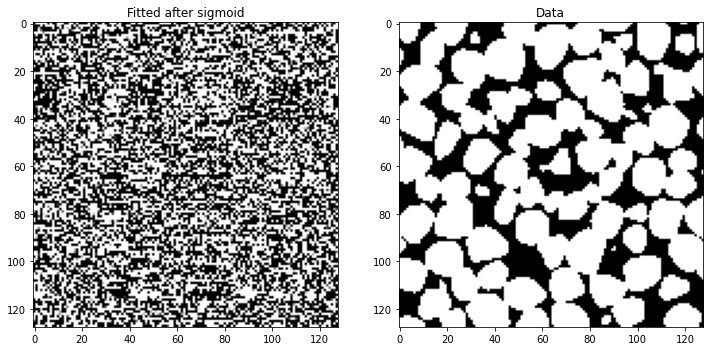

In [138]:
f, axs = plt.subplots(1,2,figsize=(12,12))
axs[0].imshow(model.tt.torch()[selection].sigmoid().detach().cpu(), cmap='gray')
axs[0].set_title("Fitted after sigmoid")
axs[1].imshow(torch_data[selection].detach().cpu(), cmap='gray')
axs[1].set_title("Data")

In [148]:
# random slices along z axis

N_slices_per_axis = 10
centers = np.random.randint(Nx, size=(N_slices, 3))

mask = np.zeros_like(data3d, dtype=np.bool)
Nx, Ny, Nz = data3d.shape
mask[centers[:,0],:,0] = True
mask[:,centers[:,1],:] = True
mask[:,:,centers[:,-1]] = True
ds_slices = SlicedDataset(data3d.shape, mask)

In [149]:
model = ModelConTT(tt=None, 
                       interpolation='closest', 
                       RMAX=RMAX, 
                       Ns=data3d.shape,
                       device=device)

ds = discreteDataset(shape=data3d.shape)

sampler = torch.utils.data.sampler.BatchSampler(
    torch.utils.data.sampler.RandomSampler(ds_slices),
    batch_size=2**14,
    drop_last=False)

dl = DataLoader(ds_slices, sampler=sampler)

none


In [150]:
losses = optimize(model, dl)

 [████████████████████████████████████████████████████████████] 10/10 [01:44<00:10, 10.44s/it]

 [████████████████████████████████████████████████████████████] 10/10 [01:49<00:11, 10.89s/it]

 [████████████████████████████████████████████████████████████] 10/10 [01:52<00:11, 11.20s/it]

 [████████████████████████████████████████████████████████████] 10/10 [01:54<00:11, 11.39s/it]

Text(0.5, 1.0, 'Data')

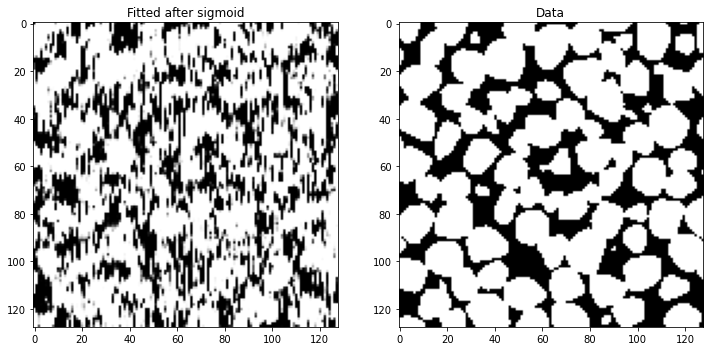

In [151]:
f, axs = plt.subplots(1,2,figsize=(12,12))
axs[0].imshow(model.tt.torch()[selection].sigmoid().detach().cpu(), cmap='gray')
axs[0].set_title("Fitted after sigmoid")
axs[1].imshow(torch_data[selection].detach().cpu(), cmap='gray')
axs[1].set_title("Data")